# Random Forest

## Import and load data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
housing_prices_df_raw = pd.read_csv('../src/data/train.csv')

In [3]:
hdf = housing_prices_df_raw.copy()
hdf = hdf.drop(columns = 'Id')

## Inspect data

In [4]:
hdf.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
hdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

## Data cleaning

### Removing outliers

In [8]:
import statsmodels.api as sm
from statsmodels.api import OLS

In [9]:
# Variable Influence Plot
# fig, ax = plt.subplots(figsize=(12, 8))
# fig = sm.graphics.influence_plot(hdf[['GrLivArea', 'SalePrice']], ax = ax, criterion = 'cooks')

In [10]:
# hdf.plot(kind = 'scatter', x = 'GrLivArea', y = 'SalePrice')
hdf = hdf[hdf['GrLivArea'] < 4000]
# hdf.plot(kind = 'scatter', x = 'GrLivArea', y = 'SalePrice')

In [11]:
# hdf.plot(kind = 'scatter', x = 'LotArea', y = 'SalePrice')
hdf = hdf.loc[hdf['LotArea'] < 100000,:]

In [12]:
# hdf.plot(kind = 'scatter', x = 'LotFrontage', y = 'SalePrice')
hdf = hdf.loc[hdf['LotFrontage'] < 250, ]

### Finding NAs

Check for NAs in all predictors:

In [13]:
hdf.loc[:,hdf.isnull().sum() > 0]
hdf.isnull().sum()[hdf.isnull().sum() > 0]

Alley           1109
MasVnrType         6
MasVnrArea         6
BsmtQual          31
BsmtCond          31
BsmtExposure      32
BsmtFinType1      31
BsmtFinType2      32
Electrical         1
FireplaceQu      600
GarageType        74
GarageYrBlt       74
GarageFinish      74
GarageQual        74
GarageCond        74
PoolQC          1191
Fence            968
MiscFeature     1156
dtype: int64

In [14]:
# In terms of proportion
round(100*hdf.isnull().sum()[hdf.isnull().sum() > 0]/len(hdf), 2)

Alley           92.80
MasVnrType       0.50
MasVnrArea       0.50
BsmtQual         2.59
BsmtCond         2.59
BsmtExposure     2.68
BsmtFinType1     2.59
BsmtFinType2     2.68
Electrical       0.08
FireplaceQu     50.21
GarageType       6.19
GarageYrBlt      6.19
GarageFinish     6.19
GarageQual       6.19
GarageCond       6.19
PoolQC          99.67
Fence           81.00
MiscFeature     96.74
dtype: float64

After checking `datadescription` file, replace nulls with class:

In [15]:
hdf.loc[hdf['Fence'].isnull(),'Fence'] = 'NoFen'
hdf.loc[hdf['PoolQC'].isnull(), 'PoolQC'] = 'NoPool'
hdf.loc[hdf['FireplaceQu'].isnull(), 'FireplaceQu'] = 'NoFir'
hdf.loc[hdf['Alley'].isnull(), 'Alley'] = 'NoAcc'

for gar in ['GarageFinish', 'GarageQual', 'GarageCond', 'GarageType']:
    hdf.loc[hdf[gar].isnull(), gar] = 'NoGar'

for bsmt in ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']:
    hdf.loc[hdf[bsmt].isnull(), bsmt] = 'NoBsmt'

Impute missing values for `GarageYrBlt`:

In [16]:
# hdf.loc[hdf['GarageYrBlt'].isnull(), 'GarageYrBlt'] = round(np.mean(hdf['GarageYrBlt']))
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
hdf.loc[:,'GarageYrBlt'] = imp.fit_transform(hdf[['GarageYrBlt']])

Drop `MiscFeature` since feature is already in `miscval`:

In [17]:
hdf = hdf.drop(columns = 'MiscFeature') 
nom_feat.remove('MiscFeature')

Drop `MasVnrType`, `MasVnrArea`, and `Electrical`:

In [18]:
round(100*hdf.isnull().sum()[hdf.isnull().sum() > 0]/len(hdf), 2)

MasVnrType    0.50
MasVnrArea    0.50
Electrical    0.08
dtype: float64

In [19]:
hdf = hdf.drop(labels = hdf.loc[hdf['MasVnrType'].isnull(),:].index)
hdf = hdf.drop(labels = hdf.loc[hdf['Electrical'].isnull(),:].index)

Check to see if there are any NAs left:

In [20]:
round(100*hdf.isnull().sum()[hdf.isnull().sum() > 0]/len(hdf), 2)

Series([], dtype: float64)

### Visualizing data

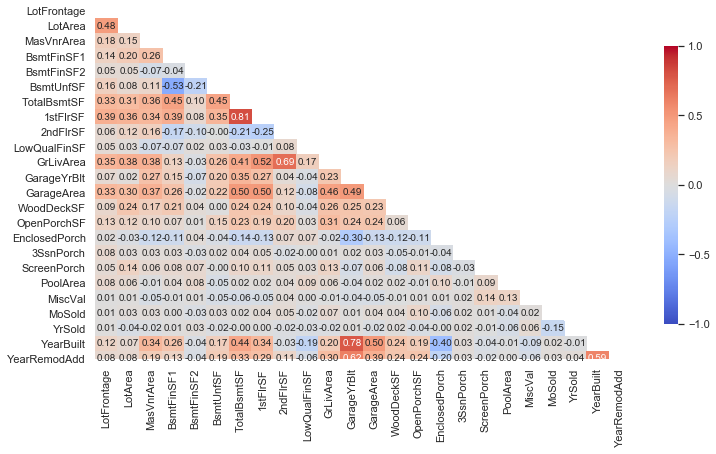

In [223]:
corr = hdf[cont_feat].corr()
mask = np.zeros(corr.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
fig, ax = plt.subplots(figsize = (12,6))
sns.heatmap(corr, annot=True, fmt='.2f', mask=mask, ax=ax, cmap='coolwarm', vmin = -1, vmax = 1, center = 0,
           cbar_kws = {'shrink': .8,'ticks': [-1, -.5, 0, 0.5, 1]})
fig.subplots_adjust(top=0.93)
sns.set_style(style = 'white')
# corr.style.background_gradient(cmap='coolwarm').set_precision(2)
# sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, 
#             mask=mask, ax=ax, cmap="coolwarm", 
#             cbar_kws = {'shrink': .6,'ticks': [-1, -.5, 0, 0.5, 1]},
#             annot=True, fmt='.2f')
# fig.subplots_adjust(top=0.93)
# # ax.set_yticklabels(corr.columns)
# ax.set_xticklabels(corr.columns, rotation = 20)
# sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

In [123]:
# List top 10 correlations
corr_asc = corr.abs().where(np.triu(np.ones(corr.abs().shape), k=1).astype(np.bool)).stack().sort_values(ascending=False)
print(corr_asc[:10])
# Filter correlations over 0.69
corr_asc[corr_asc > 0.69] 

TotalBsmtSF  1stFlrSF        0.814094
GarageYrBlt  YearBuilt       0.777219
2ndFlrSF     GrLivArea       0.694872
GarageYrBlt  YearRemodAdd    0.619802
YearBuilt    YearRemodAdd    0.593893
BsmtFinSF1   BsmtUnfSF       0.529693
1stFlrSF     GrLivArea       0.519355
TotalBsmtSF  GarageArea      0.498031
GarageArea   YearBuilt       0.496536
1stFlrSF     GarageArea      0.496010
dtype: float64


TotalBsmtSF  1stFlrSF     0.814094
GarageYrBlt  YearBuilt    0.777219
2ndFlrSF     GrLivArea    0.694872
dtype: float64

## Data preprocessing

### Define features and target

In [21]:
X = hdf.loc[:,'MSSubClass':'SaleCondition']
y = np.log1p(hdf.loc[:, 'SalePrice'])

### Encode categorical features

In [22]:
import category_encoders as ce

Identify features by variable type:

In [6]:
ord_feat  = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtCond',
             'BsmtFullBath','BsmtHalfBath', 
             
             'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces',
             
             'KitchenQual', 'FireplaceQu', 'GarageCars', 'GarageQual', 'GarageCond',
             'Functional', 'PoolQC', 'BsmtQual'
             ]

nom_feat  = ['LotShape', 'LandContour', 'LotConfig', 'MSZoning', 'Street', 
             'Alley', 'Neighborhood', 'Condition1', 'Condition2', 'MSSubClass', 
             'BldgType', 'HouseStyle', 'LandSlope', 'Exterior1st', 'Exterior2nd',
             'Foundation', 'MasVnrType', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2',
             'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'Utilities',
             'GarageType', 'GarageFinish', 'PavedDrive', 'Fence','MiscFeature',
             'SaleType', 'SaleCondition', 'RoofStyle', 'RoofMatl'
            ]

cont_feat = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
             'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
             'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
             'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
             
             'MoSold', 'YrSold', 'YearBuilt', 'YearRemodAdd'
            ]

#### Ordinal

In [34]:
ord_enc = ce.OrdinalEncoder(cols=ord_feat).fit(X,y)
X = ord_enc.transform(X)

#### Nominal

In [24]:
perm = np.random.permutation(len(X))
X = X.iloc[perm].reset_index(drop=True)
y = y.iloc[perm].reset_index(drop=True)

nom_enc = ce.CatBoostEncoder(cols=nom_feat).fit(X,y)
X = nom_enc.transform(X)

### Split dataset into training and testing data sets

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Model: Random Forest

In [27]:
from sklearn.ensemble import RandomForestRegressor

### Choose hyperparameters

Narrow down search for wide range of values for hyperparameters:

In [28]:
from sklearn.model_selection import RandomizedSearchCV
import pprint as p

In [29]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, 
                                            stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [30]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [31]:
p.pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [42]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 5-fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=2, 
                               random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.3min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [43]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

Evaluate combination of settings from randomized search:

In [44]:
from sklearn.model_selection import GridSearchCV

In [83]:
# Create parameter grid based on results of random search
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [None],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 5, 10],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [100, 200, 300, 1000]
}

# Initlize grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 5, n_jobs = -1, verbose = 2)

In [84]:
#Fit grid search to data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   56.2s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_

In [88]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 1000}

### Make predictions

### Evaluate model performance